In [46]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
%matplotlib inline
import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import utils 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 

import time 

In [2]:
df = pd.read_csv('rt5.csv') #загружаем данные в dataframe
df = df.iloc[:, :2] #извлечём тексты обращений и соответствующие им категории
df.head(10)    #посмотрим на содержимое

,topics,text
0,Россия,"Как считает эксперт, россиянам не стоит пережи..."
1,Спорт,«Конор может посетить поединок Хабиба с Порье»...
2,Россия,"Открывая заседание Госсовета в Кремле, Путин п..."
3,Мир,Об этом информируетnРИА Новостиnсо ссылкой на ...
4,Спорт,Решением 134-й сессии МОК в швейцарской Лозанн...
5,Без политики,"Поnпрогнозуn, в ближайшее время с сохранением ..."
6,Новости партнёров,Главы ведущих отечественных оборонно-промышлен...
7,Россия,«Проводятся рейды по выявлению мест для игр де...
8,Бывший СССР,"«Что касается российского Крыма, вся эта админ..."
9,Спорт,«Моё субъективное мнение — РПЛ надо обязательн...


In [3]:
print(df.shape) #Выведем форму таблицы

(8888, 2)


In [4]:
print(df.values[0]) #Выведем пример из таблицы 

['Россия'
 'Как считает эксперт, россиянам не стоит переживать, что их заподозрят в намеренном загрязнении госзнака в непогоду.n«Когда идёт дождь или снег, то у водителя нет никакого умысла, чтобы номер был грязным, — он сам по себе такой. В теории в идеальной ситуации это должно учитываться инспекторами и судом», —nзаявилnон.nРанее пленум Верховного суда Россииnвыпустил постановлениеn, разъясняющее, какие санкции могут быть применены в отношении автолюбителей, которые приняли меры, чтобы государственные знаки, установленные на их автомобилях, стали нечитаемыми.nРуководитель Федерации автовладельцев России Сергей Канаев в беседе с ФАНnоценилnпредложение правительства России ввести штраф до 2500 рублей для автомобилистов, которые не оплачивают проезд по платной дороге.']


In [5]:
for cl in df['topics'].unique(): 
  print('Количество записей класса ', cl, ': ', df[df.topics == cl].shape[0])
  

Количество записей класса  Россия :  2376
Количество записей класса  Спорт :  1965
Количество записей класса  Мир :  2795
Количество записей класса  Без политики :  366
Количество записей класса  Новости партнёров :  1
Количество записей класса  Бывший СССР :  935
Количество записей класса  Экономика :  297
Количество записей класса  Наука :  141
Количество записей класса  Мероприятия RT :  1
Количество записей класса  Пресс-релизы :  11


In [6]:
texts = df['text'].values #Извлекаем данные всех текстов из столбца text
classes = list(df['topics'].values) #Извлекаем соответствующие им значения классов (лейблов) 
maxWordsCount = 60000 #Зададим максимальное количество слов/индексов, учитываемое при обучении текстов

print(df['topics'].unique()) #Выводим все уникальные значения классов
nClasses = df['topics'].nunique()+1  #Задаём количество классов, обращаясь к столбцу category и оставляя уникальные значения
print(nClasses) #Посмотрим на количество классов

['Россия' 'Спорт' 'Мир' 'Без политики' 'Новости партнёров' 'Бывший СССР'
 'Экономика' 'Наука' 'Мероприятия RT' 'Пресс-релизы']
11


In [7]:
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(texts) 

#Формируем матрицу индексов по принципу Bag of Words
xAll = tokenizer.texts_to_matrix(texts) 
print(xAll.shape)  
print(xAll[0, :20])

(8888, 60000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1.]


In [8]:
#подключаем GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.compat.v1.Session(config=config)

In [9]:
print("Размер словаря", len(tokenizer.word_index.items()))

Размер словаря 150887


In [10]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() 
encoder.fit(classes) 
classesEncoded = encoder.transform(classes) # Кодируем категории
print(encoder.classes_)
print(classesEncoded.shape)
print(classesEncoded[:11])

['Без политики' 'Бывший СССР' 'Мероприятия RT' 'Мир' 'Наука'
 'Новости партнёров' 'Пресс-релизы' 'Россия' 'Спорт' 'Экономика']
(8888,)
[7 8 7 3 8 0 5 7 1 8 7]


In [11]:
yAll = utils.to_categorical(classesEncoded, nClasses) 
print(yAll.shape) 
print(yAll[0]) 

(8888, 11)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [12]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.3, shuffle = True)
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

(6221, 60000)
(6221, 11)


In [13]:
# для Эмбэддинга представляем текст в виде последовательности индексов слов, каждый из которых затем преобразуем в многомерный вектор
Sequences = tokenizer.texts_to_sequences(texts) 
npSequences = np.array(Sequences)                
xTrainE, xValE, yTrainE, yValE = train_test_split(npSequences, yAll, test_size=0.3)#сформируем новую форму выборки
print(xTrainE.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrainE.shape)  

(6221,)
(6221, 11)


/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


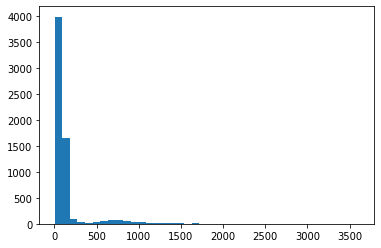

In [14]:
lenXTrainE = [len(x) for x in xTrainE]
plt.hist(lenXTrainE, 40)
plt.show()

In [15]:
maxlen = 400
xTrainE = pad_sequences(xTrainE, maxlen=maxlen) #Преобразуем входные векторы
xValE = pad_sequences(xValE, maxlen=maxlen) #Преобразуем входные векторы

Epoch 1/45
312/312 [==============================] - 13s 40ms/step - loss: 2.1292 - accuracy: 0.3088 - val_loss: 1.5863 - val_accuracy: 0.4466
Epoch 2/45
312/312 [==============================] - 13s 40ms/step - loss: 0.5825 - accuracy: 0.8159 - val_loss: 0.8753 - val_accuracy: 0.7030
Epoch 3/45
312/312 [==============================] - 13s 41ms/step - loss: 0.1929 - accuracy: 0.9502 - val_loss: 0.7723 - val_accuracy: 0.7473
Epoch 4/45
312/312 [==============================] - 13s 41ms/step - loss: 0.0833 - accuracy: 0.9809 - val_loss: 0.7868 - val_accuracy: 0.7507
Epoch 5/45
312/312 [==============================] - 13s 41ms/step - loss: 0.0679 - accuracy: 0.9826 - val_loss: 0.7786 - val_accuracy: 0.7619
Epoch 6/45
312/312 [==============================] - 14s 45ms/step - loss: 0.0504 - accuracy: 0.9889 - val_loss: 0.8764 - val_accuracy: 0.7469
Epoch 7/45
312/312 [==============================] - 13s 40ms/step - loss: 0.0433 - accuracy: 0.9879 - val_loss: 0.8846 - val_accuracy:

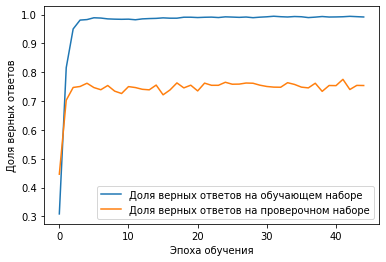

In [16]:
#Создаём полносвязную сеть
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 50, input_length=maxlen))
modelE.add(SpatialDropout1D(0.2))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(64, activation="relu"))
modelE.add(Dropout(0.2))
modelE.add(BatchNormalization())

#Выходной полносвязный слой
modelE.add(Dense(nClasses, activation='softmax'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на xTrain
history = modelE.fit(xTrainE, 
                    yTrainE, 
                    epochs=15,
                    batch_size=20,
                    validation_data=(xValE, yValE))


plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

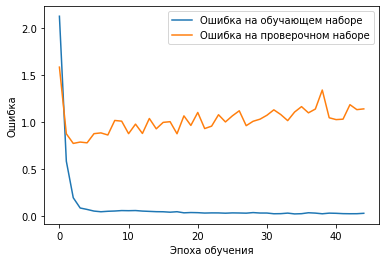

In [17]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [18]:
#Посмотрим на готовую модель
modelE.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 50)           3000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 400, 50)          0         
 ropout1D)                                                       
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 batch_normalization (BatchN  (None, 20000)            80000     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                1280064   
                                                                 
 dropout (Dropout)           (None, 64)                0

In [32]:
# Подготовка к предсказанию рубрики

def getPredictOnText(text, modelE, classes, tokenizer):

    pad_seq = getPadSequences([text.split()], tokenizer, maxlen=maxlen)

    pred = modelE.predict(pad_seq)
    
   # test_acc = modelE.evaluate(text, classes)

    predCat = classes[np.argmax(pred[0])]



    print('\n\nКатегория:', predCat)
    print(pred)
    
   # print('Test accuracy:', test_acc)

In [33]:


def getPadSequences(text, tokenizer, maxlen):

    seq = tokenizer.texts_to_sequences(text)
    pad_seq = pad_sequences(seq, maxlen=maxlen)

    return pad_seq

In [34]:
# Вводим текст для распознавания

art = 'В военном городке под Степанакертом отметили годовщину прекращения военных действий в Нагорном Карабахе. Российские миротворцы провели показательные выступления и организовали'

In [35]:
# Запуск распознавания

text = art
getPredictOnText(text, modelE, classes, tokenizer)




Категория: Мир
[[1.2207643e-02 3.3055716e-03 2.9658446e-05 7.6447153e-01 7.8555290e-04
  5.2229167e-05 1.1345524e-04 2.1858592e-01 3.4280826e-04 7.9193109e-05
  2.6432834e-05]]


In [ ]:
#Сохраним веса и модель
modelE.save('news.h5')


# For TENSORFLOW SERVING set (пока не работает)

In [38]:
MODEL_DIR = '/news/our_models'# создание временной директории для хранения модели
version = 1  # номер нашей версии
export_path = os.path.join(MODEL_DIR, str(version)) 
print('Путь для экспорта = {}\n'.format(export_path))

Путь для экспорта = /news/our_models/1



In [39]:
if os.path.isdir(export_path):
  print('\nМодель уже сохранена\n')
  !rm -r {export_path}

In [53]:
tf.saved_model(
    tf.compat.v1.keras.backend.get_session (), # Получаем Keras сессию и сохраняем модель
    export_path,

    # Значение подписи определяется входящими и исходящими тензорами
    # И сохраняется с обслуживающим по умолчанию (serving) ключом 
    inputs={'text': modelE.input},
    outputs={t.predCat:t for t in modelE.outputs})

print('\nСохраненная модель:')
!ls -l {export_path}

AttributeError: 'KerasTensor' object has no attribute 'predCat'